In [192]:
from dataclasses import dataclass
from typing import Optional, Tuple, List
import numpy as np
import pandas as pd
from math import sqrt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

In [193]:
# ---------- Device picker (CUDA -> MPS -> CPU) ----------
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

In [194]:
# =========================
# 2) CONFIG OBJECTS
# =========================
@dataclass
class SplitConfig:
    train_frac: float = 0.70
    val_frac: float   = 0.15
    # test_frac is implied as 1 - train_frac - val_frac


@dataclass
class WindowConfig:
    lookback: int = 72        # past steps per sample
    horizon: int  = 1         # number of steps to predict (1 for one-step ahead)


@dataclass
class TrainConfig:
    batch_size: int = 64
    epochs: int = 50
    patience: int = 8
    min_delta: float = 1e-4
    lr: float = 1e-3
    num_workers: int = 0
    pin_memory: bool = False

In [195]:
# =========================
# 3) DATA PREP PIPELINE
# =========================
class SeriesSplitter:
    """
    Split a 1D or 2D array into train/val/test by fractions, preserving order.
    Use when your data is already ordered by time.
    """
    def __init__(self, cfg: SplitConfig):
        self.cfg = cfg

    def split(self, arr: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        n = len(arr)
        train_size = int(self.cfg.train_frac * n)
        val_size   = int(self.cfg.val_frac * n)
        test_size  = n - train_size - val_size

        tr = arr[:train_size]
        va = arr[train_size: train_size + val_size]
        te = arr[train_size + val_size:]

        print(f"Train={len(tr)} ({len(tr)/n:.1%}) | Val={len(va)} ({len(va)/n:.1%}) | Test={len(te)} ({len(te)/n:.1%})")
        return tr, va, te

In [196]:
class Scalers:
    """
    Hold separate scalers for X (features) and y (target).
    - X can be multivariate: shape [..., n_features]
    - y is univariate by default here, but supports horizon > 1
    """
    def __init__(self):
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()

    def fit_transform(
        self, X_tr: np.ndarray, y_tr: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        X_tr_scaled = self.x_scaler.fit_transform(X_tr)
        y_tr_scaled = self.y_scaler.fit_transform(y_tr.reshape(-1, 1)).ravel()
        return X_tr_scaled, y_tr_scaled

    def transform_X(self, X: np.ndarray) -> np.ndarray:
        return self.x_scaler.transform(X)

    def transform_y(self, y: np.ndarray) -> np.ndarray:
        return self.y_scaler.transform(y.reshape(-1, 1)).ravel()

    def inverse_y(self, y_scaled: np.ndarray) -> np.ndarray:
        """
        Accepts shape [N] or [N, H]. Returns original scale in same shape.
        """
        if y_scaled.ndim == 1:
            return self.y_scaler.inverse_transform(y_scaled.reshape(-1, 1)).ravel()
        else:
            flat = y_scaled.reshape(-1, 1)
            inv = self.y_scaler.inverse_transform(flat).ravel()
            return inv.reshape(y_scaled.shape)

In [197]:
def make_windows(
    X_1d_or_2d: np.ndarray,
    y_1d: np.ndarray,
    lookback: int,
    horizon: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sliding windows.
    Inputs:
      - X_1d_or_2d: shape [N, n_features] or [N] (will be treated as [N, 1])
      - y_1d:       shape [N]
    Returns:
      - X_seq: [N_windows, lookback, n_features]
      - y_seq: [N_windows] if horizon=1, else [N_windows, horizon]
    """
    if X_1d_or_2d.ndim == 1:
        X2 = X_1d_or_2d.reshape(-1, 1)
    else:
        X2 = X_1d_or_2d
    n, n_features = X2.shape

    X_seq, y_seq = [], []
    last_start = n - lookback - horizon + 1
    for t in range(lookback, lookback + last_start):
        # window spans [t-lookback, t)
        X_seq.append(X2[t - lookback:t, :])
        if horizon == 1:
            y_seq.append(y_1d[t])                   # next single point
        else:
            y_seq.append(y_1d[t: t + horizon])      # next H points
    X_seq = np.asarray(X_seq, dtype=np.float32)      # [Nw, L, F]
    y_seq = np.asarray(y_seq, dtype=np.float32)      # [Nw] or [Nw, H]
    return X_seq, y_seq


class SeqDataset(Dataset):
    """Simple dataset wrapping the prebuilt sequences."""
    def __init__(self, X_seq: np.ndarray, y_seq: np.ndarray):
        self.X = torch.tensor(X_seq, dtype=torch.float32)    # [N, L, F]
        self.y = torch.tensor(y_seq, dtype=torch.float32)    # [N] or [N, H]

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class DataModule:
    """
    End-to-end data module:
    - splits
    - scaling
    - windowing
    - loaders
    Works with multi-feature X and 1D y.
    """
    def __init__(
        self,
        X_df: pd.DataFrame,     # all predictors (can be one or many columns)
        y_s:  pd.Series,        # target series
        split_cfg: SplitConfig,
        win_cfg: WindowConfig,
        train_cfg: TrainConfig
    ):
        self.X_df = X_df
        self.y_s  = y_s
        self.split_cfg = split_cfg
        self.win_cfg   = win_cfg
        self.train_cfg = train_cfg
        self.scalers   = Scalers()

        # Will be filled by setup()
        self.train_loader = self.val_loader = self.test_loader = None
        self.X_te_seq = self.y_te_seq = None  # cached for plotting/baselines

    def setup(self):
        # 1) Split X and y (preserving time order)
        splitter = SeriesSplitter(self.split_cfg)
        X_tr_raw, X_va_raw, X_te_raw = splitter.split(self.X_df.values.astype(np.float32))
        y_tr_raw, y_va_raw, y_te_raw = splitter.split(self.y_s.values.astype(np.float32))

        # 2) Fit scalers on train only, transform all
        X_tr_scaled, y_tr_scaled = self.scalers.fit_transform(X_tr_raw, y_tr_raw)
        X_va_scaled = self.scalers.transform_X(X_va_raw)
        X_te_scaled = self.scalers.transform_X(X_te_raw)
        y_va_scaled = self.scalers.transform_y(y_va_raw)
        y_te_scaled = self.scalers.transform_y(y_te_raw)

        print("Scaled train y: mean=", round(y_tr_scaled.mean(), 3),
              "std=", round(y_tr_scaled.std(), 3))

        # 3) Make windows
        L, H = self.win_cfg.lookback, self.win_cfg.horizon
        X_tr_seq, y_tr_seq = make_windows(X_tr_scaled, y_tr_scaled, L, H)
        X_va_seq, y_va_seq = make_windows(X_va_scaled, y_va_scaled, L, H)
        X_te_seq, y_te_seq = make_windows(X_te_scaled, y_te_scaled, L, H)

        # Cache test windows for evaluation plots/baselines
        self.X_te_seq, self.y_te_seq = X_te_seq, y_te_seq

        # 4) Build datasets and loaders
        train_ds = SeqDataset(X_tr_seq, y_tr_seq)
        val_ds   = SeqDataset(X_va_seq, y_va_seq)
        test_ds  = SeqDataset(X_te_seq, y_te_seq)

        self.train_loader = DataLoader(
            train_ds, batch_size=self.train_cfg.batch_size, shuffle=True,
            num_workers=self.train_cfg.num_workers, pin_memory=self.train_cfg.pin_memory
        )
        self.val_loader = DataLoader(
            val_ds, batch_size=self.train_cfg.batch_size, shuffle=False,
            num_workers=self.train_cfg.num_workers, pin_memory=self.train_cfg.pin_memory
        )
        self.test_loader = DataLoader(
            test_ds, batch_size=self.train_cfg.batch_size, shuffle=False,
            num_workers=self.train_cfg.num_workers, pin_memory=self.train_cfg.pin_memory
        )

        print(f"Batches → train={len(self.train_loader)} val={len(self.val_loader)} test={len(self.test_loader)}")



In [198]:
# =========================
# 4) MODEL
# =========================
class LSTMForecaster(nn.Module):
    """
    LSTM forecaster that supports:
    - multivariate inputs (input_size = n_features)
    - multi-step outputs (horizon > 1)
    - optional MLP head for nonlinearity before the final projection
    """
    def __init__(
        self,
        input_size: int,
        hidden_size: int = 64,
        num_layers: int = 1,
        dropout: float = 0.2,
        horizon: int = 1,
        mlp_hidden: Optional[int] = None
    ):
        super().__init__()
        self.horizon = horizon

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        head = []
        if mlp_hidden is not None:
            head += [nn.Linear(hidden_size, mlp_hidden), nn.ReLU()]
            head += [nn.Linear(mlp_hidden, horizon)]
        else:
            head += [nn.Linear(hidden_size, horizon)]
        self.head = nn.Sequential(*head)

    def forward(self, x):
        """
        x: [B, L, F]
        returns:
          - [B] if horizon=1
          - [B, H] if horizon>1
        """
        out, _ = self.lstm(x)     # [B, L, H]
        last = out[:, -1, :]      # [B, H] (summary of the window)
        yhat = self.head(last)    # [B, horizon]
        if self.horizon == 1:
            return yhat.squeeze(-1)  # [B]
        return yhat                 # [B, H]

In [199]:
# =========================
# 5) TRAINING LOOP (readable)
# =========================
def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        # (optional) clip RNN grads for stability:
        # nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval()
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

def fit(model, dm: DataModule, train_cfg: TrainConfig, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=train_cfg.lr)
    loss_fn = nn.MSELoss()
    model.to(device)

    best_val, best_state, bad = float("inf"), None, 0

    for epoch in range(1, train_cfg.epochs + 1):
        tr = train_one_epoch(model, dm.train_loader, loss_fn, optimizer, device)
        va = evaluate(model, dm.val_loader, loss_fn, device)
        print(f"Epoch {epoch:03d} | Train MSE: {tr:.4f} | Val MSE: {va:.4f}")

        if va < best_val - train_cfg.min_delta:
            best_val = va
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= train_cfg.patience:
                print("⏹ Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        model.to(device)
    return model

In [200]:
# =========================
# 6) EVALUATION HELPERS
# =========================
@torch.no_grad()
def predict_all(model, loader, device) -> np.ndarray:
    """Return predictions (concatenated) on scaled space; shape [N] or [N, H]."""
    model.eval()
    out = []
    for xb, _ in loader:
        xb = xb.to(device)
        yhat = model(xb).detach().cpu().numpy()
        out.append(yhat)
    yhat_all = np.concatenate(out, axis=0)
    return yhat_all

def regression_report(
    model, loader, scalers: Scalers, device, horizon: int
):
    """
    Compute MAE/RMSE on original scale.
    Works for horizon=1 and horizon>1 (averages over steps if H>1).
    """
    # 1) collect predictions and truths (scaled)
    yhat_scaled = predict_all(model, loader, device)
    y_scaled = np.concatenate([yb.numpy() for _, yb in loader], axis=0)

    # 2) inverse-scale y and yhat
    yhat = scalers.inverse_y(yhat_scaled)
    ytrue = scalers.inverse_y(y_scaled)

    # 3) metrics
    if horizon == 1:
        mae  = np.mean(np.abs(yhat - ytrue))
        rmse = sqrt(np.mean((yhat - ytrue) ** 2))
    else:
        mae  = np.mean(np.abs(yhat - ytrue))          # average over all steps
        rmse = sqrt(np.mean((yhat - ytrue) ** 2))

    return mae, rmse, yhat, ytrue

def naive_baseline_from_windows(
    X_seq_scaled: np.ndarray, y_seq_scaled: np.ndarray, scalers: Scalers, horizon: int
):
    """
    Naïve: predict 'next = last observed in the window' (or repeat that for H steps).
    """
    last_vals_scaled = X_seq_scaled[:, -1, 0]  # use feature 0 as naive source (e.g., target itself)
    if horizon == 1:
        naive_scaled = last_vals_scaled
    else:
        # repeat last value across horizon steps: [N, H]
        naive_scaled = np.repeat(last_vals_scaled[:, None], horizon, axis=1)

    naive_inv = scalers.inverse_y(naive_scaled)
    y_inv     = scalers.inverse_y(y_seq_scaled)

    mae  = np.mean(np.abs(naive_inv - y_inv))
    rmse = sqrt(np.mean((naive_inv - y_inv) ** 2))
    return mae, rmse, naive_inv

def plot_test_curves(ytrue_te, yhat_te, naive_te, title="Test set: True vs LSTM vs Naïve"):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=ytrue_te.squeeze(), mode="lines", name="True"))
    fig.add_trace(go.Scatter(y=yhat_te.squeeze(),  mode="lines", name="LSTM"))
    fig.add_trace(go.Scatter(y=naive_te.squeeze(), mode="lines", name="Naïve (last value)", line=dict(dash="dot")))
    fig.update_layout(
        title=title,
        xaxis_title="Time step (relative in test set)",
        yaxis_title="Target value",
        template="plotly_white",
        legend=dict(x=0, y=1, bgcolor='rgba(0,0,0,0)')
    )
    fig.show()

In [201]:


def add_cyclical_time_features(df: pd.DataFrame,
                               hour_col: str = "hr",
                               month_col: str = "mnth",
                               season_col: str = "season",
                               year_col: str = "yr") -> pd.DataFrame:
    """
    Add sinusoidal encodings for cyclical time features:
      - hour (0–23)
      - month (1–12)
      - season (1–4)
      - year (0 or 1 for BikeSharing dataset: 0=2011, 1=2012)

    Returns a new DataFrame with *_sin and *_cos columns appended.
    """

    out = df.copy()

    # ----- Hour of day -----
    h = out[hour_col].astype(float)
    out["hr_sin"] = np.sin(2 * np.pi * h / 24.0)
    out["hr_cos"] = np.cos(2 * np.pi * h / 24.0)

    # ----- Month (1–12) -----
    m = out[month_col].astype(float)
    out["mnth_sin"] = np.sin(2 * np.pi * (m - 1) / 12.0)
    out["mnth_cos"] = np.cos(2 * np.pi * (m - 1) / 12.0)

    # ----- Season (1–4) -----
    s = out[season_col].astype(float)
    out["season_sin"] = np.sin(2 * np.pi * (s - 1) / 4.0)
    out["season_cos"] = np.cos(2 * np.pi * (s - 1) / 4.0)

    # ----- Year (0,1) treated as binary cycle -----
    # With only two values, it's technically not cyclic, but we encode it consistently.
    y = out[year_col].astype(float)
    out["yr_sin"] = np.sin(2 * np.pi * y / 2.0)
    out["yr_cos"] = np.cos(2 * np.pi * y / 2.0)

    return out

def add_lag_features(df, target_col="cnt", lags=(24, 168)):
    """
    Adds past-target columns like cnt_lag_24, cnt_lag_168.
    IMPORTANT: lags are created BEFORE any split to avoid leakage.
    After shifting, drop the first max(lags) rows (they're NaN by design).
    """
    out = df.copy()
    for L in lags:
        out[f"{target_col}_lag_{L}"] = out[target_col].shift(L)
    maxlag = max(lags) if len(lags) else 0
    if maxlag > 0:
        out = out.iloc[maxlag:].copy()  # drop initial NaNs safely
    return out



In [202]:
# =========================
# 7) END-TO-END USAGE
# =========================
# Suppose you have a pandas DataFrame 'df' with columns:
#   - features: e.g., ["cnt", "temp", "hum", "windspeed", ...]  (you choose)
#   - target:   e.g., "cnt"
#
# Example:
# features = ["cnt"]                        # univariate
# OR
# features = ["cnt", "temp", "hum"]        # multivariate
#
# X_df = df[features]
# y_s  = df["cnt"]

# --- configs ---
# split_cfg  = SplitConfig(train_frac=0.70, val_frac=0.15)
# win_cfg    = WindowConfig(lookback=48, horizon=1)       # set horizon=5 for 5-step-ahead
# train_cfg  = TrainConfig(batch_size=64, epochs=50, patience=5, lr=1e-3)

# --- data module ---
# dm = DataModule(X_df, y_s, split_cfg, win_cfg, train_cfg)
# dm.setup()

# --- model ---
# input_size = X_df.shape[1]
# model = LSTMForecaster(input_size=input_size, hidden_size=64, num_layers=1,
#                        dropout=0.0, horizon=win_cfg.horizon, mlp_hidden=None)

# --- train ---
# device = get_device()
# model = fit(model, dm, train_cfg, device)

# --- evaluate (train/val/test) ---
# for name, loader in [("Train", dm.train_loader), ("Val", dm.val_loader), ("Test", dm.test_loader)]:
#     mae, rmse, yhat, ytrue = regression_report(model, loader, dm.scalers, device, win_cfg.horizon)
#     print(f"LSTM → {name} MAE={mae:.3f} RMSE={rmse:.3f}")

# --- naive baseline on TEST (uses cached windows) ---
# na_mae, na_rmse, naive_curve = naive_baseline_from_windows(dm.X_te_seq, dm.y_te_seq, dm.scalers, win_cfg.horizon)
# print(f"Naïve → Test MAE={na_mae:.3f} RMSE={na_rmse:.3f}")

# --- quick plot (horizon==1 case plots as lines easily; for H>1 you might plot step k) ---
# if win_cfg.horizon == 1:
#     _, _, yhat_te, ytrue_te = regression_report(model, dm.test_loader, dm.scalers, device, win_cfg.horizon)
#     plot_test_curves(ytrue_te, yhat_te, naive_curve)

In [203]:
# df = pd.read_csv("data/hour.csv", parse_dates=["dteday"])
# y = df['cnt'].astype(float).dropna()
# # 1) Load your BikeSharing data into a DataFrame `df`
# # df = pd.read_csv("hour.csv")  # or your path

# # 2) Choose features & target
# features = ["cnt"]          # univariate
# target   = "cnt"

# X_df = df[features]
# y_s  = df[target]

# # 3) Configs
# split_cfg = SplitConfig(train_frac=0.70, val_frac=0.15)
# win_cfg   = WindowConfig(lookback=48, horizon=1)   # 48 past hours → next hour
# train_cfg = TrainConfig(batch_size=64, epochs=50, patience=5, lr=1e-3)

# # 4) Data module
# dm = DataModule(X_df, y_s, split_cfg, win_cfg, train_cfg)
# dm.setup()

# # 5) Model
# input_size = X_df.shape[1]  # = 1
# model = LSTMForecaster(input_size=input_size, hidden_size=64, num_layers=1,
#                        dropout=0.0, horizon=win_cfg.horizon, mlp_hidden=None)

# # 6) Train
# device = get_device()  # picks cuda → mps → cpu
# model = fit(model, dm, train_cfg, device)

# # 7) Evaluate (on original scale)
# for name, loader in [("Train", dm.train_loader), ("Val", dm.val_loader), ("Test", dm.test_loader)]:
#     mae, rmse, yhat, ytrue = regression_report(model, loader, dm.scalers, device, win_cfg.horizon)
#     print(f"LSTM → {name} MAE={mae:.3f} RMSE={rmse:.3f}")

# # 8) Naïve baseline + plot
# na_mae, na_rmse, naive_curve = naive_baseline_from_windows(dm.X_te_seq, dm.y_te_seq, dm.scalers, win_cfg.horizon)
# print(f"Naïve → Test MAE={na_mae:.3f} RMSE={na_rmse:.3f}")

# if win_cfg.horizon == 1:
#     _, _, yhat_te, ytrue_te = regression_report(model, dm.test_loader, dm.scalers, device, win_cfg.horizon)
#     plot_test_curves(ytrue_te, yhat_te, naive_curve, title="Univariate (cnt) — Test")


In [213]:
# 1) Features & target
df = pd.read_csv("data/hour.csv", parse_dates=["dteday"])

df_feat = add_cyclical_time_features(df,
                                     hour_col="hr",
                                     month_col="mnth",
                                     season_col="season",
                                     year_col="yr")

df_feat = add_lag_features(df_feat, target_col="cnt", lags=(24,)) # add 24h lag

features = ["cnt", "cnt_lag_24",'weathersit', 'temp', 'hum', 'windspeed',
            "hr_sin", "hr_cos", "mnth_sin", "mnth_cos", "season_sin", "season_cos", "yr_sin", "yr_cos"]
target   = "cnt"


X_df = df_feat[features]
y_s  = df_feat[target]


# 2) (optional) If you have categorical cols (e.g., season, weathersit), one-hot encode them first:
# X_df = pd.get_dummies(X_df, columns=["season", "weathersit"], drop_first=True)

# 3) Reuse configs (you can keep lookback/horizon identical for fair comparison)
split_cfg = SplitConfig(train_frac=0.70, val_frac=0.15)
win_cfg   = WindowConfig(lookback=72, horizon=1)
train_cfg = TrainConfig(batch_size=64, epochs=50, patience=8, lr=1e-3)

# 4) Data module
dm = DataModule(X_df, y_s, split_cfg, win_cfg, train_cfg)
dm.setup()

# 5) Model with new input_size
input_size = X_df.shape[1]  # now = 4 (or more if one-hot expanded)
model = LSTMForecaster(input_size=input_size, hidden_size=128, num_layers=3,
                       dropout=0.2, horizon=win_cfg.horizon, mlp_hidden=None)

# 6) Train
device = get_device()
model = fit(model, dm, train_cfg, device)

# 7) Evaluate + compare to naive
for name, loader in [("Train", dm.train_loader), ("Val", dm.val_loader), ("Test", dm.test_loader)]:
    mae, rmse, yhat, ytrue = regression_report(model, loader, dm.scalers, device, win_cfg.horizon)
    print(f"LSTM (multi) → {name} MAE={mae:.3f} RMSE={rmse:.3f}")

na_mae, na_rmse, naive_curve = naive_baseline_from_windows(dm.X_te_seq, dm.y_te_seq, dm.scalers, win_cfg.horizon)
print(f"Naïve → Test MAE={na_mae:.3f} RMSE={na_rmse:.3f}")

if win_cfg.horizon == 1:
    _, _, yhat_te, ytrue_te = regression_report(model, dm.test_loader, dm.scalers, device, win_cfg.horizon)
    plot_test_curves(ytrue_te, yhat_te, naive_curve, title="Multivariate (cnt+weather) — Test")


Train=12148 (70.0%) | Val=2603 (15.0%) | Test=2604 (15.0%)
Train=12148 (70.0%) | Val=2603 (15.0%) | Test=2604 (15.0%)
Scaled train y: mean= 0.0 std= 1.0
Batches → train=189 val=40 test=40
Epoch 001 | Train MSE: 0.2881 | Val MSE: 0.3833
Epoch 002 | Train MSE: 0.0876 | Val MSE: 0.2398
Epoch 003 | Train MSE: 0.0658 | Val MSE: 0.1954
Epoch 004 | Train MSE: 0.0600 | Val MSE: 0.2010
Epoch 005 | Train MSE: 0.0524 | Val MSE: 0.2376
Epoch 006 | Train MSE: 0.0496 | Val MSE: 0.1881
Epoch 007 | Train MSE: 0.0518 | Val MSE: 0.1904
Epoch 008 | Train MSE: 0.0456 | Val MSE: 0.2655
Epoch 009 | Train MSE: 0.0437 | Val MSE: 0.1695
Epoch 010 | Train MSE: 0.0424 | Val MSE: 0.1935
Epoch 011 | Train MSE: 0.0424 | Val MSE: 0.1785
Epoch 012 | Train MSE: 0.0398 | Val MSE: 0.1570
Epoch 013 | Train MSE: 0.0389 | Val MSE: 0.1613
Epoch 014 | Train MSE: 0.0377 | Val MSE: 0.1713
Epoch 015 | Train MSE: 0.0370 | Val MSE: 0.1401
Epoch 016 | Train MSE: 0.0363 | Val MSE: 0.2240
Epoch 017 | Train MSE: 0.0350 | Val MSE: 0.1

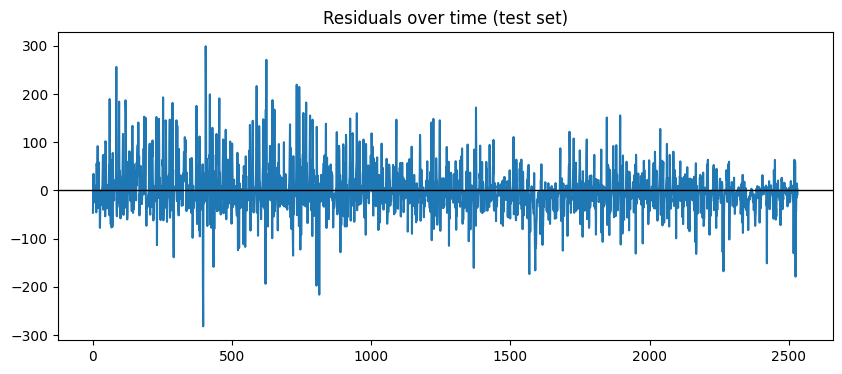

In [205]:
import matplotlib.pyplot as plt

residuals = ytrue_te - yhat_te  # same scale as target
res_df = pd.DataFrame({
    "true": ytrue_te,
    "pred": yhat_te,
    "residual": residuals
})
plt.figure(figsize=(10,4))
plt.plot(res_df["residual"])
plt.axhline(0, color="black", lw=1)
plt.title("Residuals over time (test set)")
plt.show()


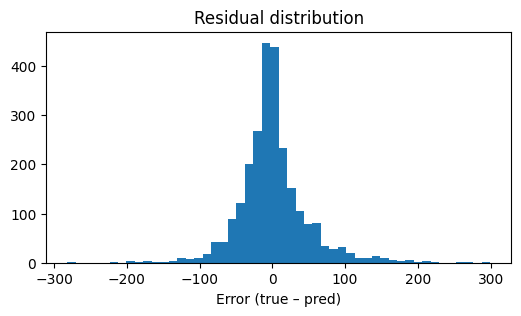

In [206]:
plt.figure(figsize=(6,3))
plt.hist(res_df["residual"], bins=50)
plt.title("Residual distribution")
plt.xlabel("Error (true – pred)")
plt.show()


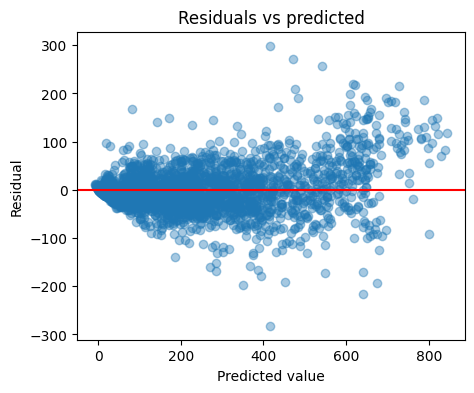

In [207]:
plt.figure(figsize=(5,4))
plt.scatter(res_df["pred"], res_df["residual"], alpha=0.4)
plt.axhline(0, color="red")
plt.xlabel("Predicted value")
plt.ylabel("Residual")
plt.title("Residuals vs predicted")
plt.show()


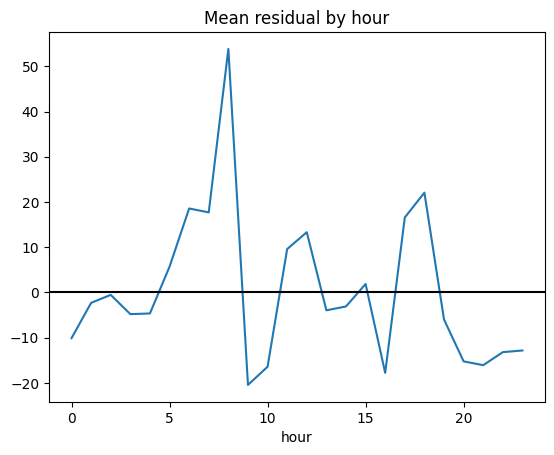

In [208]:
# If you still have ytrue_te and yhat_te (both NumPy arrays)
# and you know dm.y_te_seq came from your test set:
indices_test = df_feat.index[-len(dm.y_te_seq):]  # match test-window count
res_df["hour"] = df_feat.loc[indices_test, "hr"].to_numpy()
res_df["season"] = df_feat.loc[indices_test, "season"].to_numpy()
res_df.groupby("hour")["residual"].mean().plot(title="Mean residual by hour")
plt.axhline(0, color="black")
plt.show()



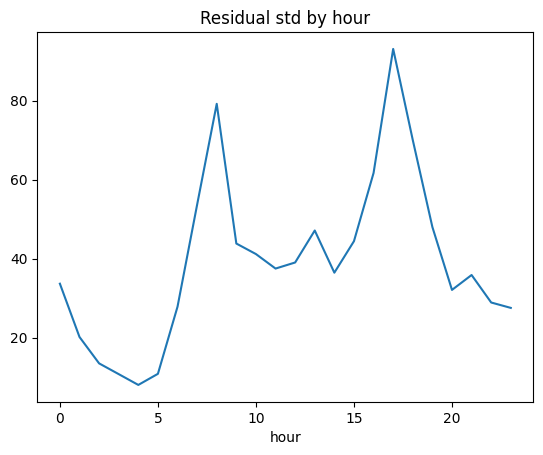

In [209]:
res_df.groupby("hour")["residual"].std().plot(title="Residual std by hour")
plt.show()


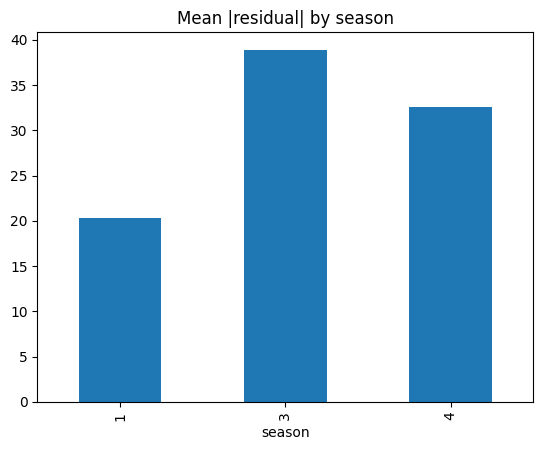

In [210]:
res_df["abs_resid"] = res_df["residual"].abs()
res_df.groupby("season")["abs_resid"].mean().plot.bar(title="Mean |residual| by season")
plt.show()


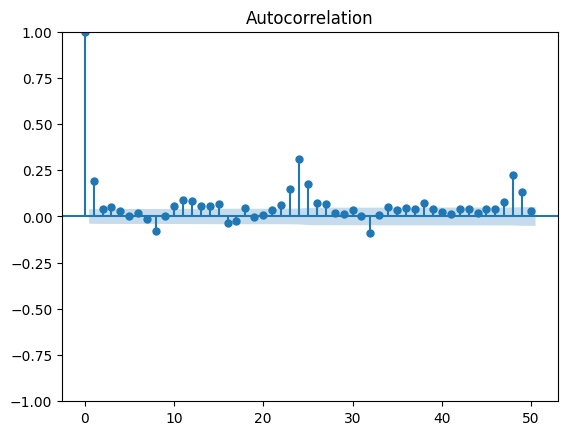

In [211]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(res_df["residual"], lags=50)
plt.show()


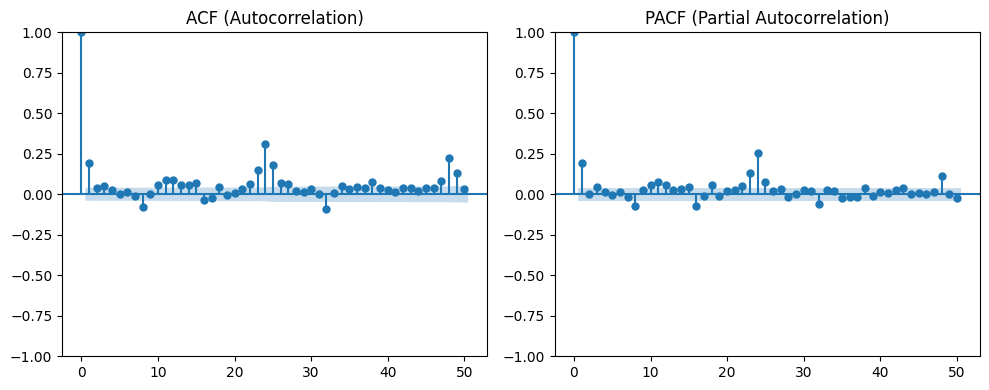

In [212]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(res_df["residual"], lags=50, ax=ax[0])
plot_pacf(res_df["residual"], lags=50, ax=ax[1], method="ywm")  # "ywm" = safe default
ax[0].set_title("ACF (Autocorrelation)")
ax[1].set_title("PACF (Partial Autocorrelation)")
plt.tight_layout()
plt.show()
